Files already downloaded and verified


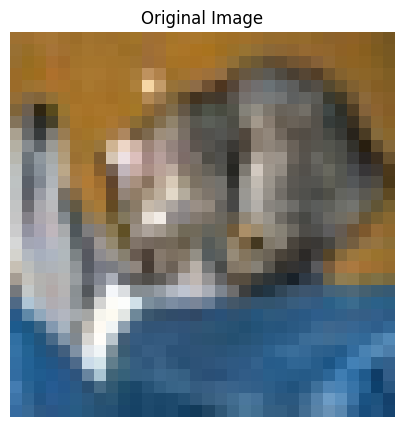

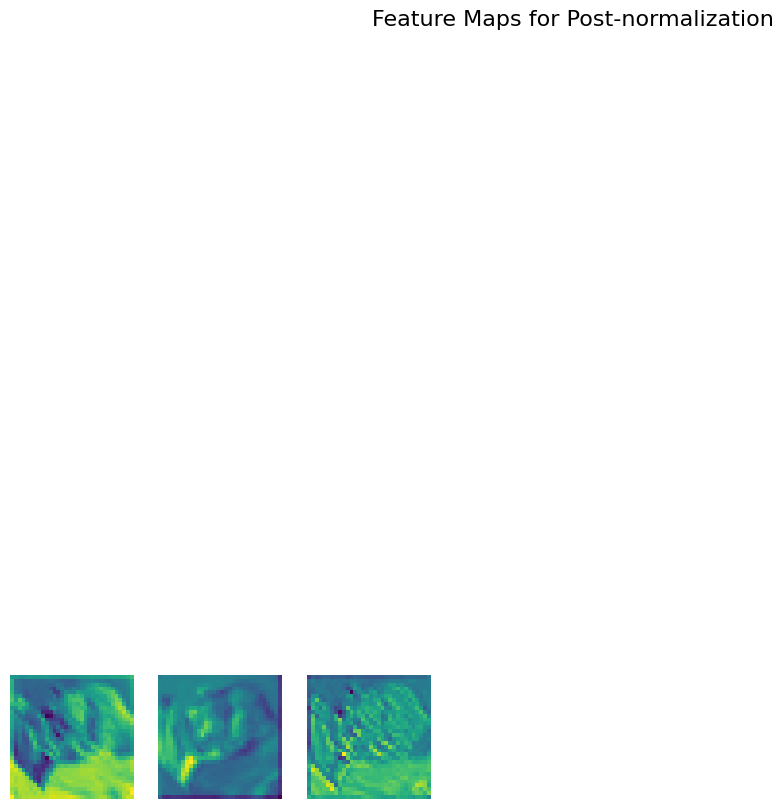

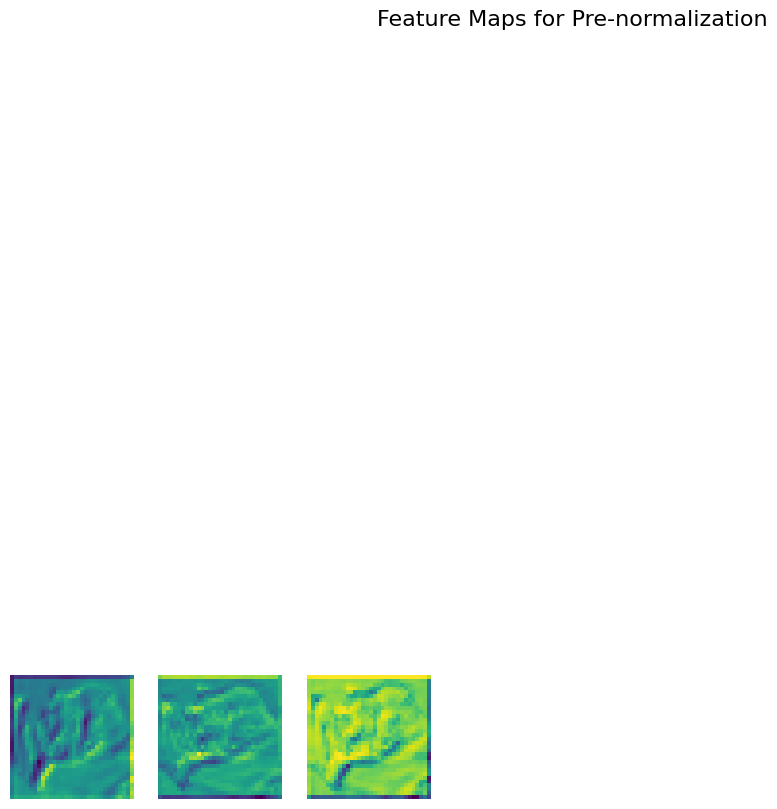

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np

def plot_feature_maps(feature_maps, title, num_cols=8):
    num_feature_maps = feature_maps.shape[1]
    num_rows = np.ceil(num_feature_maps / num_cols).astype(int)
    plt.figure(figsize=(15, 15))
    for i in range(num_feature_maps):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(feature_maps[0, i].detach().numpy(), cmap='viridis')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

def show_original_image(image_tensor, title="Original Image"):
    image_np = image_tensor.squeeze(0).permute(1, 2, 0).numpy()
    plt.figure(figsize=(5, 5))
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(title)
    plt.show()

class PostNormalizationCombination(nn.Module):
    def __init__(self, in_channels):
        super(PostNormalizationCombination, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.query = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        conv_out = self.depthwise_conv(x)
        
        # Self-attention
        B, C, H, W = x.size()
        query = self.query(x).view(B, C, -1)  
        key = self.key(x).view(B, C, -1)      
        value = self.value(x).view(B, C, -1) 

        attention = F.softmax(torch.bmm(query.transpose(1, 2), key), dim=-1) 
        attn_out = torch.bmm(value, attention)  
        attn_out = attn_out.view(B, C, H, W)  

        return conv_out + attn_out

class PreNormalizationCombination(nn.Module):
    def __init__(self, in_channels):
        super(PreNormalizationCombination, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.query = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        conv_out = self.depthwise_conv(x)

        B, C, H, W = x.size()
        query = self.query(x).view(B, C, -1)  
        key = self.key(x).view(B, C, -1)     
        value = self.value(x).view(B, C, -1) 

        attention = F.softmax(torch.bmm(query.transpose(1, 2), key), dim=-1) 
        attn_out = torch.bmm(value, attention)  
        attn_out = attn_out.view(B, C, H, W) 

        combined_out = F.normalize(conv_out + attn_out, dim=1)
        return combined_out

transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
sample_image, _ = dataset[0]
sample_image = sample_image.unsqueeze(0)  

show_original_image(sample_image, title="Original Image")

in_channels = sample_image.size(1)

post_norm_model = PostNormalizationCombination(in_channels)
pre_norm_model = PreNormalizationCombination(in_channels)

with torch.no_grad():
    post_norm_feature_maps = post_norm_model(sample_image)
    pre_norm_feature_maps = pre_norm_model(sample_image)

plot_feature_maps(post_norm_feature_maps, title="Feature Maps for Post-normalization")

plot_feature_maps(pre_norm_feature_maps, title="Feature Maps for Pre-normalization")